# Load Processor and Model

In [ ]:
# Imports
import torch
from PIL import Image
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration
import json
import time
from distance import levenshtein
from peft import LoraConfig


C:\Anaconda3\envs\Idefics2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device('cpu')
device

'cuda'

In [ ]:
# Load Processor
processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting = False)

# Processor attributes
processor.attributes

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['image_processor', 'tokenizer']

In [ ]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True


# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    lora_Config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )


    model.add_adapter(lora_Config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # Only available on A100 or H100
    ).to(DEVICE)



`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|                                                                 | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:  14%|████████▏                                                | 1/7 [00:03<00:20,  3.44s/it]

Loading checkpoint shards:  29%|████████████████▎                                        | 2/7 [00:07<00:17,  3.52s/it]

Loading checkpoint shards:  43%|████████████████████████▍                                | 3/7 [00:10<00:13,  3.44s/it]

Loading checkpoint shards:  57%|████████████████████████████████▌                        | 4/7 [00:13<00:10,  3.39s/it]

Loading checkpoint shards:  71%|████████████████████████████████████████▋                | 5/7 [00:17<00:06,  3.42s/it]

Loading checkpoint shards:  86%|████████████████████████████████████████████████▊        | 6/7 [00:20<00:03,  3.53s/it]

Loading checkpoint shards: 100%|███████████████████████████████████████████████

# Load dataset

In [ ]:
from datasets import load_from_disk

dataset = load_from_disk(r"E:\Abdul_Muqtadir\Thesis\Dataset\Test_Iamlatex2\iamlatex_processed_dataset2")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 600
    })
    valid: Dataset({
        features: ['image', 'text'],
        num_rows: 135
    })
})

Random sample from 'train' is 254
Ground Truth is {'latex_1': 'd G _ { 4 } / 2 \\pi = d \\rho \\land e _ { 4 } / 2', 'latex_2': '\\frac { K } { \\Lambda } = \\tan \\beta .', 'latex_3': '\\sin \\lambda = - \\frac { i \\rho } { 2 \\zeta } ,', 'latex_4': 'X = y + v _ { 1 } T = z + v _ { 2 } T', 'latex_5': '0 \\leq \\sigma \\lt 4 \\pi l , 0 \\leq \\tau \\lt \\pi .', 'latex_6': '\\lt T _ { \\mu \\nu } \\gt _ { f i n } ^ { i n } =', 'latex_7': '\\Delta = C ^ { 2 } - \\frac { 1 } { 2 } \\lt 0 .', 'latex_8': 'S = - \\frac { T } { 2 }'}


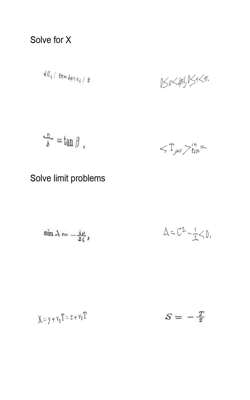

In [ ]:
import random
random_sample_train = random.randint(0, len(dataset['train']) - 1)
print(f"Random sample from 'train' is {random_sample_train}")
print(f"Ground Truth is {dataset['train'][random_sample_train]['text']}")
dataset['train'][random_sample_train]['image'].resize((250, 400))

In [ ]:

special_tokens = ['<s_latex0>', '</s_latex0>', '<s_latex1>', '</s_latex1>', '<s_latex2>', '</s_latex2>', '<s_latex3>', '</s_latex3>', '<s_latex4>', '</s_latex4>', '<s_latex5>', '</s_latex5>', '<s_latex6>', '</s_latex6>', '<s_latex7>', '</s_latex7>', '<s_latex8>', '</s_latex8>', '<s_latex9>', '</s_latex9>' ]

In [ ]:
def json2token(data):
    # Initialize an empty string to build the formatted output
    formatted_output = ''

    # Loop through each key-value pair in the dictionary
    for key, value in data.items():
        # Remove commas and format each pair without single quotes
        #value = str(value).replace(',', '')  # Remove commas
        value = str(value).replace('.', '')
        formatted_output += f"<s_{key}>{value}</s_{key}>"

    # Return the final formatted output string
    return formatted_output.strip()  # Remove trailing whitespace

In [ ]:
import json

task_start_token = '<s>'
eos_token = '</s>'

def process_documents(sample):

  GT_string_single_quote = sample["text"]
  GT_string_single_quote = str(GT_string_single_quote)
  #print(type(sample["text"]))

  GT_string_double_quote = GT_string_single_quote.replace("'", '"')
  text = json.loads(GT_string_double_quote)
  d_doc = task_start_token + json2token(text) + eos_token
  print('d_doc', d_doc)
  image = sample["image"].convert('RGB')
  return {"image": image, "text": d_doc}

In [ ]:
class TupleDatasetWrapper:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        target_sequence = sample["text"]
        return image, target_sequence

    def __len__(self):
        return len(self.dataset)



In [ ]:

valid_dataset = dataset['valid']

# Apply the map function to the dataset
proc_valid_dataset = valid_dataset.map(process_documents)

# Wrap the dataset in the custom wrapper to ensure tuple-based output
proc_valid_dataset = TupleDatasetWrapper(proc_valid_dataset)

In [ ]:
train_dataset = dataset['train']
proc_train_dataset = train_dataset.map(process_documents)

# Wrap the dataset in the custom wrapper to ensure tuple-based output
proc_train_dataset = TupleDatasetWrapper(proc_train_dataset)

In [ ]:
train_example = proc_valid_dataset[0]
image, target_sequence = train_example
print(target_sequence)

<s><s_latex_1>\Phi ^ { 2 } = B ^ { - 1 } , K = C B - A ^ { 2 } </s_latex_1><s_latex_2>\frac { \alpha } { \alpha ^ { 2 } + 1 } = 0 </s_latex_2><s_latex_3>\frac { \pi } { \pi + g N } p \lt 1 ,</s_latex_3><s_latex_4>x _ { \mu } ^ { c } = x _ { \mu } + A _ { \mu } </s_latex_4><s_latex_5>m _ { 3 / 2 } = \frac { \omega } { \rho }</s_latex_5><s_latex_6>\lbrack p , q \rbrack = \frac { 2 \pi i } { N } ,</s_latex_6><s_latex_7>\hat { \nabla } _ { m } \tilde { \eta } = 0 </s_latex_7><s_latex_8>D _ { 1 } a = \frac { 1 } { 2 } D _ { 2 } z ,</s_latex_8></s>


In [ ]:
USE_ADD_ADAPTER = True

from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

if not USE_ADD_ADAPTER:
    lora_config = LoraConfig(
            r=8,
            lora_alpha=8,
            lora_dropout=0.1,
            target_modules=".*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$",
            use_dora=False if USE_QLORA else True,
            init_lora_weights="gaussian",
        )

    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)

# token setup

In [ ]:
print(model.get_input_embeddings().weight.shape)


torch.Size([32003, 4096])


In [ ]:
processor.tokenizer.add_special_tokens({"additional_special_tokens": special_tokens + [task_start_token] + [eos_token]})

20

In [ ]:
model.resize_token_embeddings(len(processor.tokenizer))

Embedding(32023, 4096)

# dataset processed

In [ ]:
processor.tokenizer.add_special_tokens({"additional_special_tokens": ["<image>"]})

0

In [ ]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[processor.tokenizer.additional_special_tokens.index("<image>")]
print(f"<image> token ID: {image_token_id}")


<image> token ID: 32001


In [ ]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[processor.tokenizer.additional_special_tokens.index("<image>")]
MAX_LENGTH = 768

def train_collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        image, ground_truth = example
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Extract JSON."},
                    {"type": "image"},
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": ground_truth}
                ]
            }
        ]
        text = processor.apply_chat_template(messages, add_generation_prompt=False)
        texts.append(text.strip())
        images.append([image])

    batch = processor(text=texts, images=images, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == model.config.image_token_id] = -100
    batch["labels"] = labels

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    pixel_attention_mask = batch["pixel_attention_mask"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values, pixel_attention_mask, labels


def eval_collate_fn(examples):

    # we feed the prompt to the model
    images = []
    texts = []
    answers = []
    for example in examples:
        image, ground_truth = example
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Extract JSON."},
                    {"type": "image"},
                ]
            },
        ]
        text = processor.apply_chat_template(messages, add_generation_prompt=True)
        images.append([image])
        texts.append(text.strip())
        answers.append(ground_truth)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    pixel_attention_mask = batch["pixel_attention_mask"]

    return input_ids, attention_mask, pixel_values, pixel_attention_mask, answers


In [ ]:
import lightning as L
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np


class Idefics2ModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, pixel_attention_mask, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                pixel_values=pixel_values,
                                pixel_attention_mask=pixel_attention_mask,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, pixel_attention_mask, answers = batch

        # autoregressively generate token IDs
        generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, pixel_attention_mask=pixel_attention_mask,
                                       max_new_tokens=768)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(proc_train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True)

    # def val_dataloader(self):
    #     return DataLoader(proc_valid_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False)


In [ ]:
config = {"max_epochs": 4,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 2,
          "precision": "16-mixed", # we'll use mixed precision
          # "seed":2022, # can be used for reproducibility
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
}

model_module = Idefics2ModelPLModule(config, processor, model)


In [ ]:
# import os
# from lightning.pytorch.callbacks import Callback
# from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# # Define the directory to save the model
# SAVE_DIR = r"E:\Abdul_Muqtadir\Thesis\Idefics2_KIE\model_save_directory"

# class SaveToLocalCallback(Callback):
#     def __init__(self, save_dir):
#         super().__init__()
#         self.save_dir = save_dir
#         os.makedirs(self.save_dir, exist_ok=True)  # Ensure directory exists

#     def on_train_epoch_end(self, trainer, pl_module):
#         save_path = os.path.join(self.save_dir, f"model_epoch_{trainer.current_epoch}")
#         print(f"Saving model to {save_path}, epoch {trainer.current_epoch}")
#         # Save model using save_pretrained
#         pl_module.model.save_pretrained(save_path)

#     def on_train_end(self, trainer, pl_module):
#         save_path = os.path.join(self.save_dir, "final_model")
#         print(f"Saving final model to {save_path}")
#         # Save final model using save_pretrained
#         pl_module.model.save_pretrained(save_path)

# # Initialize the callback
# save_callback = SaveToLocalCallback(SAVE_DIR)

# # Early stopping callback
# early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")


In [ ]:
import wandb
wandb.finish()

In [ ]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="Idefics2", name="MathEquation_KIE6")

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        precision=config.get("precision"),
        num_sanity_val_steps=0,
        logger=wandb_logger,
        #callbacks=[save_callback, early_stop_callback],
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:

trainer.fit(model_module)

C:\Anaconda3\envs\Idefics2\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params | Mode
------------------------------------------------------------------
0 | model | Idefics2ForConditionalGeneration | 4.4 B  | eval
------------------------------------------------------------------
23.3 M    Trainable params
4.3 B     Non-trainable params
4.4 B     Total params
17,438.418Total estimated model params size (MB)
2482      Modules in train mode
835       Modules in eval mode
C:\Anaconda3\envs\Idefics2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 3: 100%|███████████████████████████████████████████████████████████| 300/300 [04:37<00:00,  1.08it/s, v_num=7wq5]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|███████████████████████████████████████████████████████████| 300/300 [05:01<00:00,  1.00it/s, v_num=7wq5]


# inference

In [ ]:
model.save_pretrained(r"E:\Abdul_Muqtadir\Thesis\Idefics2_KIE\model")

C:\Anaconda3\envs\Idefics2\lib\site-packages\transformers\integrations\peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


In [ ]:
model = Idefics2ForConditionalGeneration.from_pretrained(
    r"E:\Abdul_Muqtadir\Thesis\Idefics2_KIE\model",
    torch_dtype=torch.float16,
)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.15s/it]


In [ ]:
model.to(device)

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Extract JSON."},
            {"type": "image"},
        ]
    },
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
print(prompt)


User: Extract JSON.<image><end_of_utterance>
Assistant:


In [ ]:
from PIL import Image
test_image_path = r"E:\Abdul_Muqtadir\Thesis\Dataset\Test_Iamlatex2\test\Images\generated_template_8.jpg"

test_image = Image.open(test_image_path)


In [ ]:
model.to(DEVICE)

In [ ]:
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to(device)


In [ ]:

# Generate token IDs
generated_ids = model.generate(**inputs, max_new_tokens=768)


In [ ]:

# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

generated_texts

['User: Extract JSON. \nAssistant:  <s_latex_1>\\langle \\Gamma ^ { 4 } G _ { a } \\rangle = 0 </s_latex_1><s_latex_2>\\lim _ { E \\to \\infty } V = \\infty </s_latex_2><s_latex_3>I = I _ { B } + I _ { \\partial B } + I _ { c t }</s_latex_3><s_latex_4>\\rho = 0  5 4 = 0  1 0 ,</s_latex_4><s_latex_5>\\alpha = \\sqrt { \\frac { 1 + v } { 1 - v } } </s_latex_5><s_latex_6>\\bar { \\chi } U ^ { \\dag } Y U \\chi</s_latex_6><s_latex_7>\\bar { M } M + \\bar { D } D = \\bar { Q } Q</s_latex_7><s_latex_8>M = m + \\frac { 3 m } { e } \\ln \\sin \\beta ;</s_latex_8>']

In [ ]:
generated_texts[0]

'User: Extract JSON. \nAssistant:  <s_latex_1>\\langle \\Gamma ^ { 4 } G _ { a } \\rangle = 0 </s_latex_1><s_latex_2>\\lim _ { E \\to \\infty } V = \\infty </s_latex_2><s_latex_3>I = I _ { B } + I _ { \\partial B } + I _ { c t }</s_latex_3><s_latex_4>\\rho = 0  5 4 = 0  1 0 ,</s_latex_4><s_latex_5>\\alpha = \\sqrt { \\frac { 1 + v } { 1 - v } } </s_latex_5><s_latex_6>\\bar { \\chi } U ^ { \\dag } Y U \\chi</s_latex_6><s_latex_7>\\bar { M } M + \\bar { D } D = \\bar { Q } Q</s_latex_7><s_latex_8>M = m + \\frac { 3 m } { e } \\ln \\sin \\beta ;</s_latex_8>'

In [ ]:
def Inference(img):
  inputs = processor(text=prompt, images=[img], return_tensors="pt").to(device)

  generated_ids = model.generate(**inputs, max_new_tokens=768)

  generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

  return generated_texts[0]




In [ ]:
import re
import json

import re

def extract_latex_equations(input_str):

    #input_str
    # Regular expression to match both numbered and unknown latex tags
    matches = re.findall(r'<s_latex(?:_(\d+|<unk>))>(.*?)</s_latex(?:_\1)>', input_str)

    # Create the dictionary with formatted keys and LaTeX content
    latex_dict = {}
    for num, content in matches:
        if num == "<unk>":
            latex_dict["latex_1"] = content.strip() # Map unknown tag to latex_1
        else:
            latex_dict[f"latex_{num}"] = content.strip()

    return latex_dict



In [ ]:
import os
import json
from PIL import Image

# Define the directory containing images and JSON output directory
image_dir = r'E:\Abdul_Muqtadir\Thesis\Dataset\Test_Iamlatex2\test\Images'
json_output_dir = r'E:\Abdul_Muqtadir\Thesis\Dataset\Test_Iamlatex2/Idefics2_output'

# Create the output directory if it doesn't exist
os.makedirs(json_output_dir, exist_ok=True)

# Loop through each file in the image directory
for filename in os.listdir(image_dir):
    # Check if the file is an image (e.g., .jpg or .png)
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Convert to lowercase for consistent matching
        image_path = os.path.join(image_dir, filename)

        # Open the image using PIL
        img = Image.open(image_path)

        # Perform inference and extract LaTeX equations
        inference_text = Inference(img)
        print(inference_text)
        generated_text = extract_latex_equations(inference_text)

        # Prepare the data to be saved in JSON format
        data = generated_text
        #print(generated_text)

        # Define the output JSON file path with the same name as the image but with a .json extension
        json_filename = os.path.splitext(filename)[0] + '.json'
        json_path = os.path.join(json_output_dir, json_filename)

        # Save the generated LaTeX equation to the JSON file
        with open(json_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)

        print(f"Generated LaTeX for {filename} saved to {json_filename}")


User: Extract JSON. 
Assistant:  <s_latex_1>\delta p = \frac { 2 } { \sqrt { S } } \delta S ,</s_latex_1><s_latex_2>E ^ { 2 } = 4 + 4 \omega \lparen N + 2 \rparen </s_latex_2><s_latex_3>n _ { 2 } \simeq 2 1 - 2 \simeq - 2 5 </s_latex_3><s_latex_4>0 \leq \tau _ { i } \lt \pi / 2</s_latex_4><s_latex_5>E _ { C } R = \frac { 2 \pi } { e } S _ { \Delta } ,</s_latex_5><s_latex_6>\omega _ { k } = \frac { k + 1 } { R }</s_latex_6><s_latex_7>\tilde { g } _ { m \parallel } \geq \delta _ { 0 } </s_latex_7><s_latex_8>A U - i B V = U E ,</s_latex_8>
Generated LaTeX for generated_template_106.jpg saved to generated_template_106.json
User: Extract JSON. 
Assistant:  <s_latex_1>\partial ^ { \ast M } = D ^ { M } \eta ^ { \ast } = 0</s_latex_1><s_latex_2>L _ { T } = L _ { F } + L _ { I }</s_latex_2><s_latex_3>\psi \rightarrow - \psi</s_latex_3><s_latex_4>\Omega = P ^ { m } , \Omega ^ { 2 } = Q </s_latex_4><s_latex_5>R = 1 \otimes j \otimes \bar { k } ,</s_latex_5><s_latex_6>\delta A = \lbrack D + A , V 

In [ ]:
from donut import JSONParseEvaluator
import os
import json

def strip_spaces(data):
    """
    Recursively strip spaces from strings in a dictionary or list.
    """
    if isinstance(data, dict):
        return {k.strip(): strip_spaces(v) if isinstance(v, (dict, list)) else v.strip() if isinstance(v, str) else v for k, v in data.items()}
    elif isinstance(data, list):
        return [strip_spaces(item) for item in data]
    return data

def TED_Evaluation(Json_GT_Path, Json_Predicted_Path):
    all_scores = []
    for x in [x for x in os.listdir(Json_GT_Path) if x.endswith('.json')]:
        gt_file_path = os.path.join(Json_GT_Path, x)
        pred_file_path = os.path.join(Json_Predicted_Path, x)

        if os.path.exists(gt_file_path) and os.path.exists(pred_file_path):
            with open(gt_file_path) as f1, open(pred_file_path) as f2:
                data1 = json.load(f1)
                data2 = json.load(f2)

                # Remove spaces in keys and string values
                data1 = strip_spaces(data1)
                data2 = strip_spaces(data2)

                evaluator = JSONParseEvaluator()
                score = evaluator.cal_acc(data1, data2)
                print(x, ":", score)
                all_scores.append(score)
        else:
            print(f"File not found: {x}")

    if all_scores:
        print(sum(all_scores))
        print(len(all_scores))
        print("Average Score: ", sum(all_scores) / len(all_scores))
    else:
        print("No scores calculated.")


In [ ]:
# Donut on final dataset

model_output_path = r"E:\Abdul_Muqtadir\Thesis\Dataset\Test_Iamlatex2\test"
GT_Json_Path = r"E:\Abdul_Muqtadir\Thesis\Dataset\Test_Iamlatex2/Idefics2_output"

TED_Evaluation(GT_Json_Path, model_output_path)

generated_template_106.json : 0.6890243902439024
generated_template_129.json : 0.7107692307692308
generated_template_131.json : 0.7640117994100295
generated_template_155.json : 0.7416413373860182
generated_template_157.json : 0.9548192771084337
generated_template_158.json : 0.9807162534435262
generated_template_16.json : 0.7395498392282958
generated_template_162.json : 0.9533527696793003
generated_template_169.json : 0.8262032085561497
generated_template_17.json : 0.9340659340659341
generated_template_174.json : 0.8686567164179104
generated_template_179.json : 0.8427299703264095
generated_template_188.json : 0.6746987951807228
generated_template_221.json : 0.8220064724919094
generated_template_236.json : 0.7808641975308642
generated_template_238.json : 0.6612377850162867
generated_template_243.json : 0.7461139896373057
generated_template_244.json : 0.8468468468468469
generated_template_25.json : 0.7725856697819314
generated_template_26.json : 0.571875
generated_template_267.json : 0.82